In [ ]:
import os
import git
from pathlib import Path
from typing import List
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import plotly.graph_objects as go
from IPython.display import clear_output
import scipy
import pylustrator

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = False
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(os.path.join(ROOT_DIR, "results", "combined_results"))
np.random.seed(0)
plots_path = os.path.join(ROOT_DIR, "poster", "plots")

def variance_prior(r, eta, scale=1):
    beta = (eta+1.5)/r
    var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
    return var_prior

def kurtosis_prior(r, eta, fisher=True):
    beta = (eta+1.5)/r
    kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2 
    if fisher:
        return kurtosis - 3
    else:
        return kurtosis 

fixed_palette = {
    'gray': 'xkcd:gray',
    'green': 'xkcd:shamrock green',
    'red': 'xkcd:light red',
    'blue': 'xkcd:blue',
}

def find_master_dfs(root_dir: str) -> List[str]:
    root_path = Path(root_dir)
    if not root_path.exists():
        raise FileNotFoundError(f"Directory not found: {root_dir}")

    master_df_paths = []
    for current_dir, _, files in os.walk(root_path):
        if 'master_df.csv' in files:
            master_df_path = Path(os.path.join(current_dir, 'master_df.csv'))
            master_df_paths.append(str(master_df_path.absolute()))
    return master_df_paths

def add_hull(master_df, rEtaKsstats_dict, GROUP='group', debug=False):

    master_df_copy = master_df.copy()
    master_df_copy = master_df.set_index(GROUP)
    groups = master_df_copy.index
    master_df_copy["hull"] = ""

    for group in groups:
        if master_df_copy.loc[group, "total_samples"] < 10:
            master_df_copy.loc[group, "hull"] = np.nan
           
        else:
            drop_keys =list(rEtaKsstats_dict[group].keys())[-3:]
            if debug:
                print(drop_keys)
            pre_optimization = pd.DataFrame(rEtaKsstats_dict[group]).drop(drop_keys, axis = 1 )
            optimization = pd.DataFrame(rEtaKsstats_dict[group])[drop_keys]
            optimization = optimization.rename(columns = {"r_optimize": "r", "eta_optimize": "eta", drop_keys[-1]: "ksstat"})
            optimization = optimization.dropna()
            full_df = pre_optimization.merge(optimization, on=["r", "eta"], how="outer")
            full_df = full_df.set_index(["r", "eta"])
            full_df["ksstat"] = full_df.min(axis=1)
            full_df = full_df.reset_index()
            full_df = full_df[["r", "eta", "ksstat"]]
            full_df["1/beta"] = full_df["r"]/(full_df["eta"] + 1.5)
            MULT = 1.2
            cutoff = max(min(full_df["ksstat"]) * MULT, master_df_copy.loc[group, "kstest_stat_cutoff_0.05"], 0.01)
            filtered_df = full_df[full_df["ksstat"] < cutoff]
            points = np.column_stack((filtered_df["r"], filtered_df["1/beta"])) + stats.norm.rvs(size=(len(filtered_df), 2)) * 0.001  # Adding small noise for convex hull computation
            hull = ConvexHull(points)
            master_df_copy.loc[group, "hull"] = hull

    return master_df_copy.reset_index()

relevant_cols = ['group', 'obs_var', 'total_samples', 'best_r', 'best_eta', 'kstest_stat_best', 
                'dataset', 'subset', 'transform', 'orientation', 'channel', 'github_plot', 'dataset_type', 'hull']

all_paths = find_master_dfs(os.path.join(ROOT_DIR, "results", "case-studies"))
all_master_dfs = []
github_plots_path = "https://github.com/yashdave003/hierarchical-bayesian-model-validation/blob/main/results/case-studies/"

for path in all_paths:
    if 'scaleTesting' in path:
        continue
    master_df = pd.read_csv(path)
    master_df = master_df.rename(columns={master_df.columns[0]: 'group'})
    parts = Path(path).parts[-7:]
    if parts[0] == 'case-studies':
        parts = parts[1:]
    if "MRI" in path:
        dataset, slice, transform, orientation, _, _ = parts
        master_df['dataset'] = dataset
        master_df['transform'] = transform
        master_df['subset'] = slice
        master_df['channel'] = np.nan
        master_df['orientation'] = orientation
        master_df['github_plot'] = [github_plots_path+'/'.join([dataset, slice, transform, orientation, 'plots', f'compare_cdf_pdf_layer_{group}.jpg']) for group in master_df['group']]
    
    elif len(parts) > 6:
        dataset, subset, transform, orientation, channel, _, _ = parts
        master_df['dataset'] = dataset
        master_df['transform'] = transform
        master_df['subset'] = subset
        master_df['channel'] = channel
        master_df['orientation'] = orientation
        master_df['github_plot'] = [github_plots_path+'/'.join([dataset, subset, transform, orientation, channel, 'plots', f'compare_cdf_pdf_layer_{group}.jpg']) for group in master_df['group']]
    else:
        dataset, size, transform, channel, _, _ = parts
        master_df['dataset'] = dataset
        master_df['transform'] = transform
        master_df['subset'] = size
        master_df['channel'] = channel
        master_df['orientation'] = np.nan
        master_df['github_plot'] = [github_plots_path+'/'.join([dataset, size, transform, channel, 'plots', f'compare_cdf_pdf_layer_{group}.jpg']) for group in master_df['group']]
    
    if dataset in ['pastis', 'agriVision', 'spaceNet']:
        master_df['dataset_type'] = 'remote sensing'
    elif dataset in ['syntheticMRI2D', 'syntheticMRI3D']:
        master_df['dataset_type'] = 'medical'
    elif dataset in ['coco', 'segmentAnything']:
        master_df['dataset_type'] = 'natural'

    GROUP = 'layer' if transform.split("-")[0] == 'wavelet' else ('band' if transform.split("-")[0] == 'fourier' else 'error')
    rEtaKsstatsDict = pd.read_pickle(path[:-18] + "cache/rEtaKsstats_dict.pickle")
    master_df = add_hull(master_df, rEtaKsstatsDict)


    all_master_dfs.append(master_df[relevant_cols])
    
main_df = pd.concat(all_master_dfs)
main_df['best_beta'] = (main_df['best_eta'] + 1.5)/main_df['best_r'] 
main_df['best_1/beta'] = 1/main_df['best_beta']
main_df['total_samples'] = main_df['total_samples']//10 # TODO: look into why total_samples*10
main_df['kstest_stat_cutoff_0.10'] = stats.kstwo(n=main_df['total_samples']).isf(0.1)
kstest_stat_cutoff_2 = 0.2
kstest_stat_cutoff_2_name = 'kstest_stat_cutoff_0.20'
main_df[kstest_stat_cutoff_2_name] = stats.kstwo(n=main_df['total_samples']).isf(kstest_stat_cutoff_2)
main_df['beat_all_priors'] = (main_df['kstest_stat_best'] < np.minimum.reduce([main_df['kstest_stat_gaussian'], main_df['kstest_stat_laplace'], main_df['kstest_stat_t']])).astype(int)


frequency_map = pd.read_csv(os.path.join(ROOT_DIR, "transformed-data", "master-frequency-map.csv")).set_index(['dataset', 'transform', 'group'])
# main_df = main_df.set_index(['dataset', 'subset', 'transform', 'group']).merge(frequency_map, left_index = True, right_index=True).reset_index()
main_df = main_df.set_index(['dataset', 'subset', 'transform', 'group']).reset_index() 
print(main_df.shape)
main_df.head()

c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\scipy\stats\_continuous_distns.py:209: RuntimeWarning: divide by zero encountered in divide
  return (0.5/(n if not isinstance(n, Iterable) else np.asanyarray(n)),
c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\scipy\stats\_continuous_distns.py:209: RuntimeWarning: divide by zero encountered in divide
  return (0.5/(n if not isinstance(n, Iterable) else np.asanyarray(n)),


(733, 38)


,dataset,subset,transform,group,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,...,orientation,channel,github_plot,dataset_type,hull,best_beta,best_1/beta,kstest_stat_cutoff_0.10,kstest_stat_cutoff_0.20,beat_all_priors
0,agriVision,full,fourier,2,1292.94670,749.107670,2108.43070,421.84155,123.97443,696.23804,...,NaN,blue,https://github.com/yashdave003/hierarchical-ba...,remote sensing,<scipy.spatial._qhull.ConvexHull object at 0x0...,38.000000,0.026316,0.018207,0.015955,1
1,agriVision,full,fourier,5,662.65440,382.089750,1248.61780,628.03000,108.21224,1663.23950,...,NaN,blue,https://github.com/yashdave003/hierarchical-ba...,remote sensing,<scipy.spatial._qhull.ConvexHull object at 0x0...,43.333333,0.023077,0.011300,0.009903,1
2,agriVision,full,fourier,8,256.63390,133.792040,650.84560,1363.73070,99.36560,3639.23580,...,NaN,blue,https://github.com/yashdave003/hierarchical-ba...,remote sensing,<scipy.spatial._qhull.ConvexHull object at 0x0...,53.333333,0.018750,0.008893,0.007794,1
3,agriVision,full,fourier,11,121.96157,57.215298,390.19293,2698.31760,93.68093,4889.27800,...,NaN,blue,https://github.com/yashdave003/hierarchical-ba...,remote sensing,<scipy.spatial._qhull.ConvexHull object at 0x0...,55.555556,0.018000,0.005497,0.004818,1
4,agriVision,full,fourier,14,48.46801,23.179575,151.67955,2654.29520,86.30504,4711.62940,...,NaN,blue,https://github.com/yashdave003/hierarchical-ba...,remote sensing,<scipy.spatial._qhull.ConvexHull object at 0x0...,56.666667,0.017647,0.003633,0.003184,1


C:\Users\yashd\AppData\Local\Temp\ipykernel_34612\2923373292.py:49: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(r_mesh, eta_mesh, score_matrix_spacenet, levels=100, cmap="Greens", alpha=0.4, label="SpaceNet")
C:\Users\yashd\AppData\Local\Temp\ipykernel_34612\2923373292.py:50: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(r_mesh, eta_mesh, (score_matrix_pastis), levels=100, cmap="Blues", alpha=0.4, label="Pastis")
C:\Users\yashd\AppData\Local\Temp\ipykernel_34612\2923373292.py:51: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(r_mesh, eta_mesh, (score_matrix_agriVision), levels=100, cmap="Reds", alpha=0.4, label="AgriVision")
C:\Users\yashd\AppData\Local\Temp\ipykernel_34612\2923373292.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


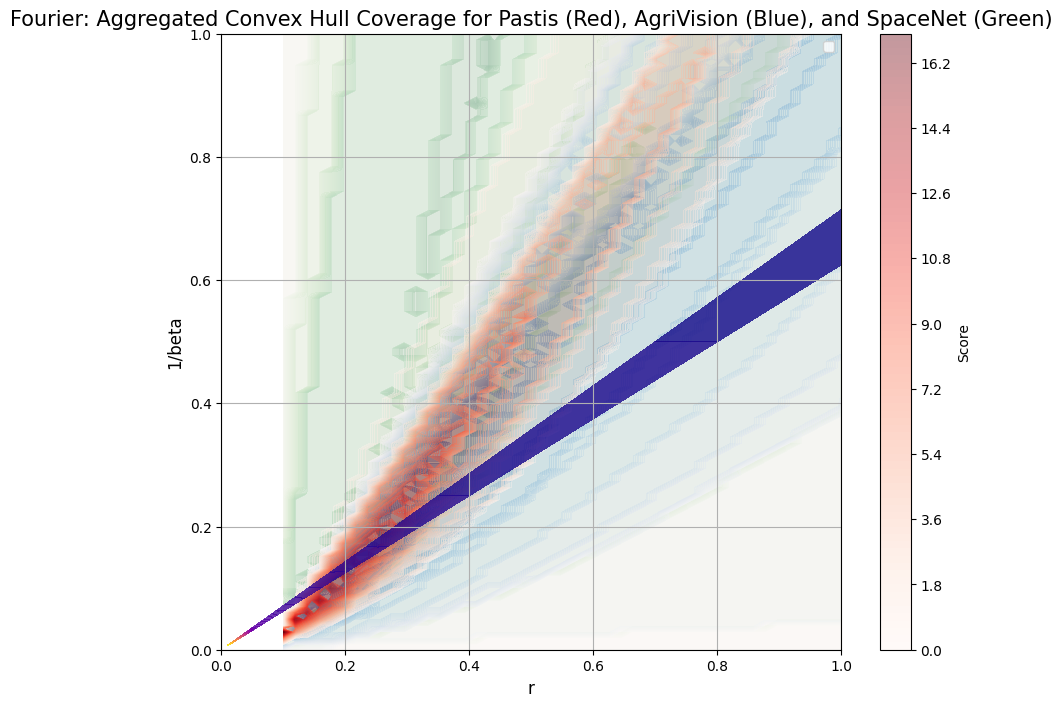

In [102]:
# Create a meshgrid of r and eta points
# temp_pastis = main_df[(main_df['dataset'] == 'syntheticMRI2D') & (main_df['transform'] == 'wavelet')& (main_df['orientation'] == 'horizontal')]
# temp_agriVision = main_df[(main_df['dataset'] == 'syntheticMRI2D') & (main_df['transform'] == 'wavelet')  & (main_df['orientation'] == 'vertical')]
# temp_spacenet = main_df[(main_df['dataset'] == 'syntheticMRI2D') & (main_df['transform'] == 'wavelet') & (main_df['orientation'] == 'diagonal')]

temp_pastis = main_df[(main_df['dataset'] == 'pastis') & (main_df['transform'] == 'wavelet') & (main_df['channel'] == 'gray')]
temp_agriVision = main_df[(main_df['dataset'] == 'agriVision') & (main_df['transform'] == 'wavelet') & (main_df['channel'] == 'gray')]
temp_spacenet = main_df[(main_df['dataset'] == 'spaceNet') & (main_df['transform'] == 'wavelet') & (main_df['channel'] == 'gray')]

# temp_pastis = main_df[(main_df['dataset_type'] == 'remote sensing') & (main_df['transform'] == 'wavelet') & (main_df['channel'] == 'gray')]
# temp_agriVision = main_df[(main_df['dataset_type'] == 'medical') & (main_df['transform'] == 'wavelet')]
# temp_spacenet = main_df[(main_df['dataset_type'] == 'natural') & (main_df['transform'] == 'wavelet') & (main_df['channel'] == 'gray')]

r_values = np.linspace(
    min(temp_pastis['best_r'].min(), temp_spacenet['best_r'].min(), temp_spacenet['best_r'].min()), 
    max(temp_pastis['best_r'].max(), temp_spacenet['best_r'].max(), temp_spacenet['best_r'].max()), 
    500
)
eta_values = np.linspace(
    min(temp_pastis['best_eta'].min(), temp_spacenet['best_eta'].min(), temp_spacenet['best_eta'].min()), 
    max(temp_pastis['best_eta'].max(), temp_spacenet['best_eta'].max(), temp_spacenet['best_eta'].max()), 
    500
)
r_mesh, eta_mesh = np.meshgrid(r_values, eta_values)
k = 1
# Initialize score matrices
score_matrix_pastis = np.zeros_like(r_mesh)
score_matrix_agriVision = np.zeros_like(r_mesh)
score_matrix_spacenet = np.zeros_like(r_mesh)

# Check if each (r, eta) pair is inside any convex hull for pastis
for hull in temp_pastis['hull'].dropna():
    path = k*(scipy.spatial.Delaunay(hull.points).find_simplex(np.column_stack((r_mesh.ravel(), eta_mesh.ravel()))) >= 0)
    score_matrix_pastis += path.reshape(r_mesh.shape)

# Check if each (r, eta) pair is inside any convex hull for agriVision
for hull in temp_agriVision['hull'].dropna():
    path = k*(scipy.spatial.Delaunay(hull.points).find_simplex(np.column_stack((r_mesh.ravel(), eta_mesh.ravel()))) >= 0)
    score_matrix_agriVision += path.reshape(r_mesh.shape)

# Check if each (r, eta) pair is inside any convex hull for spacenet
for hull in temp_spacenet['hull'].dropna():
    path = k*(scipy.spatial.Delaunay(hull.points).find_simplex(np.column_stack((r_mesh.ravel(), eta_mesh.ravel()))) >= 0)
    score_matrix_spacenet += path.reshape(r_mesh.shape)


# Visualize the score matrices
plt.figure(figsize=(10, 8))
plt.contourf(r_mesh, eta_mesh, score_matrix_spacenet, levels=100, cmap="Greens", alpha=0.4, label="SpaceNet")
plt.contourf(r_mesh, eta_mesh, (score_matrix_pastis), levels=100, cmap="Blues", alpha=0.4, label="Pastis")
plt.contourf(r_mesh, eta_mesh, (score_matrix_agriVision), levels=100, cmap="Reds", alpha=0.4, label="AgriVision")
plt.colorbar(label="Score")
plt.title("Fourier: Aggregated Convex Hull Coverage for Pastis (Red), AgriVision (Blue), and SpaceNet (Green)", fontsize=15)
plt.xlabel("r", fontsize=12)
plt.ylabel("1/beta", fontsize=12)
plt.grid(True)
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)

# Add the region of interest (ROI) to the plot
plt.contourf(r_roi_mesh, 1 / beta_roi_mesh, beta_roi_mesh, levels=100, cmap="plasma", alpha=0.8)
plt.show()

In [103]:
r_shade_roi = np.linspace(0.01, 4, 100)
eta_shade_roi = np.linspace(-0.1, 0.1, 100)
beta_shade_roi = (eta_shade_roi + 1.5)/r_shade_roi

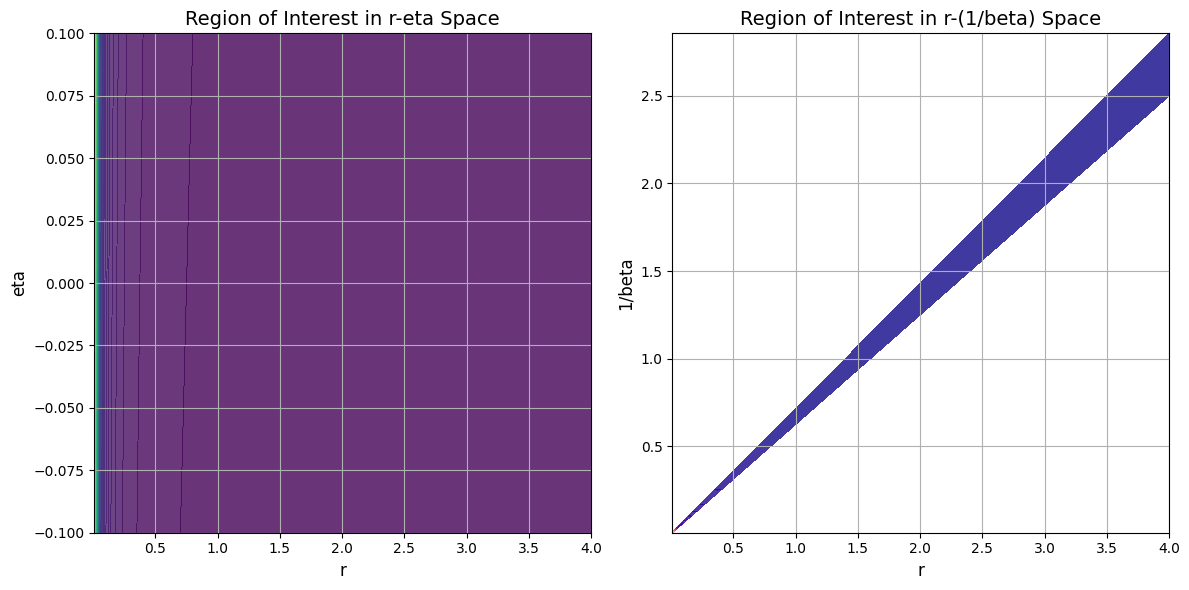

In [104]:
# Create meshgrid for the region of interest (ROI)
r_roi_mesh, eta_roi_mesh = np.meshgrid(r_shade_roi, eta_shade_roi)
beta_roi_mesh = (eta_roi_mesh + 1.5) / r_roi_mesh

# Plot the ROI in r-eta space and r-(1/beta) space side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot r-eta space
axes[0].contourf(r_roi_mesh, eta_roi_mesh, beta_roi_mesh, levels=100, cmap="viridis", alpha=0.8)
axes[0].set_title("Region of Interest in r-eta Space", fontsize=14)
axes[0].set_xlabel("r", fontsize=12)
axes[0].set_ylabel("eta", fontsize=12)
axes[0].grid(True)

# Plot r-(1/beta) space
axes[1].contourf(r_roi_mesh, 1 / beta_roi_mesh, beta_roi_mesh, levels=100, cmap="plasma", alpha=0.8)
axes[1].set_title("Region of Interest in r-(1/beta) Space", fontsize=14)
axes[1].set_xlabel("r", fontsize=12)
axes[1].set_ylabel("1/beta", fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()

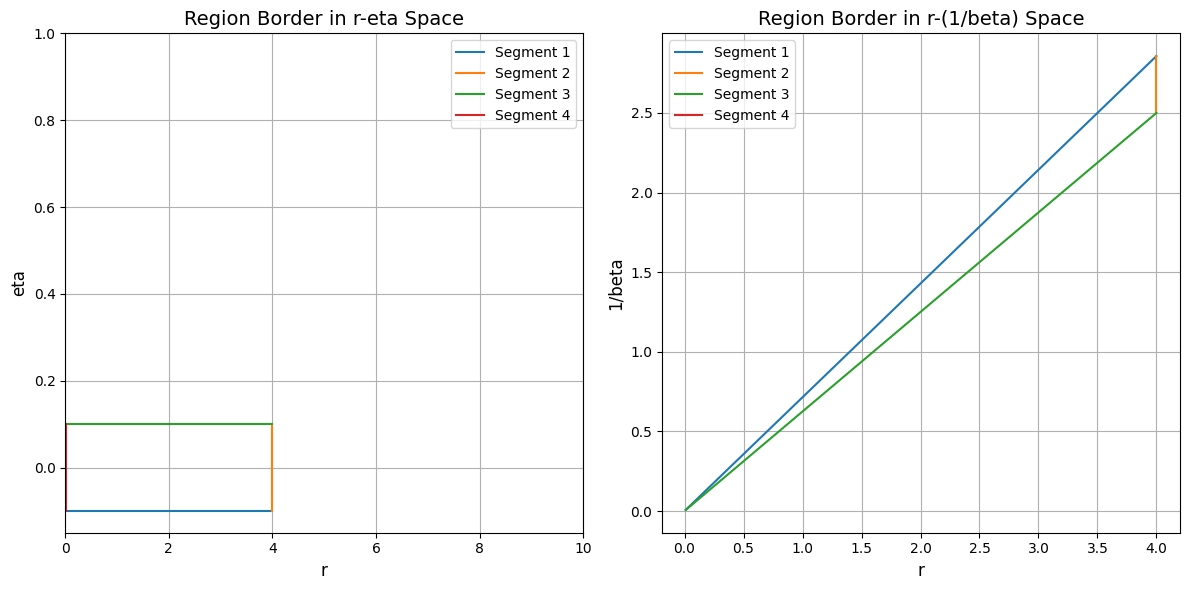

In [105]:
# Extract the borders of the region of interest (ROI)
x_border = [r_shade_roi[0], r_shade_roi[-1], r_shade_roi[-1], r_shade_roi[0], r_shade_roi[0]]
y_border = [eta_shade_roi[0], eta_shade_roi[0], eta_shade_roi[-1], eta_shade_roi[-1], eta_shade_roi[0]]

# Calculate the borders in r-(1/beta) space
beta_border = (np.array(y_border) + 1.5) / np.array(x_border)
x_border_beta = x_border
y_border_beta = 1 / beta_border

# Plot the borders in r-eta space and r-(1/beta) space side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot r-eta space
for i in range(len(x_border) - 1):
    axes[0].plot(x_border[i:i+2], y_border[i:i+2], color=f"C{i}", label=f"Segment {i+1}")
axes[0].set_title("Region Border in r-eta Space", fontsize=14)
axes[0].set_xlabel("r", fontsize=12)
axes[0].set_ylabel("eta", fontsize=12)
axes[0].set_xlim((0, 10))
axes[0].set_ylim((-.15, 1))
axes[0].grid(True)
axes[0].legend()

# Plot r-(1/beta) space
for i in range(len(x_border_beta) - 1):
    axes[1].plot(x_border_beta[i:i+2], y_border_beta[i:i+2], color=f"C{i}", label=f"Segment {i+1}")
axes[1].set_title("Region Border in r-(1/beta) Space", fontsize=14)
axes[1].set_xlabel("r", fontsize=12)
axes[1].set_ylabel("1/beta", fontsize=12)
axes[0].set_xlim((0, 10))
axes[0].set_ylim((-.15, 1))
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

<Axes: >

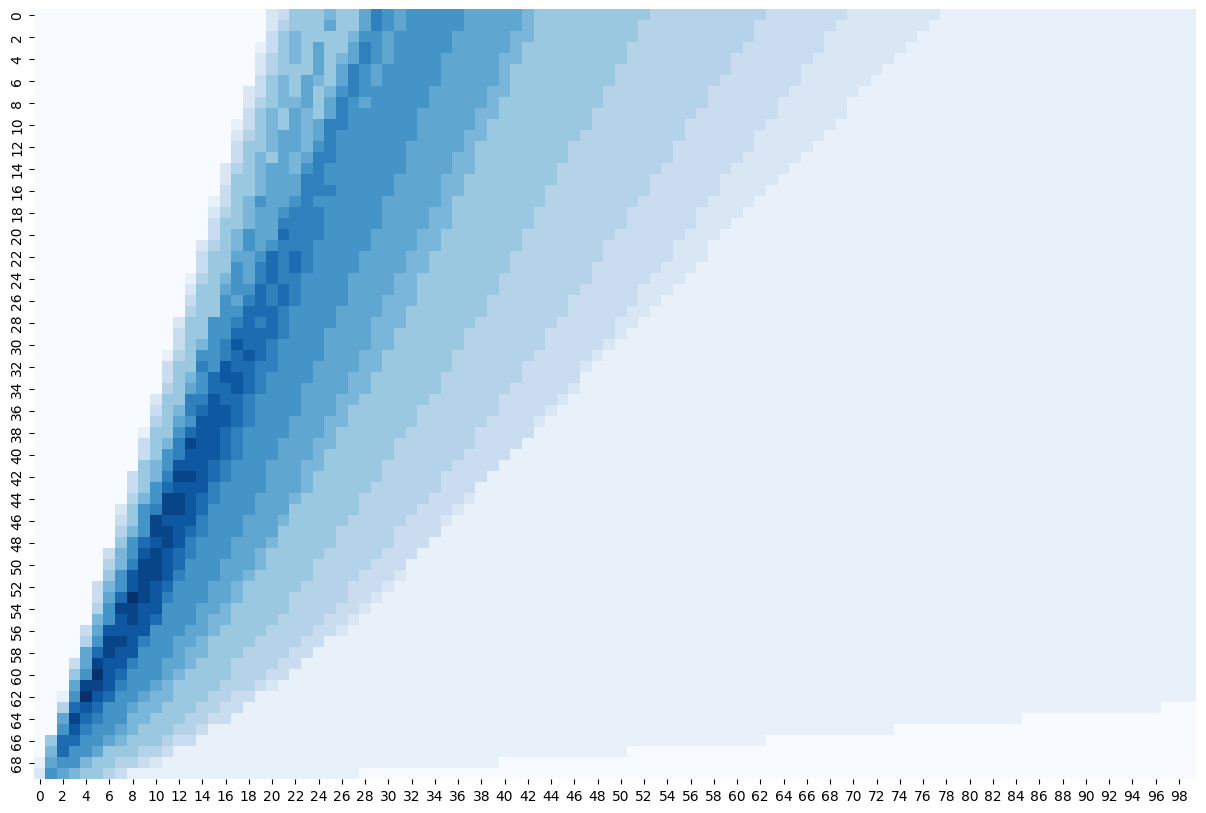

In [106]:
# Define variables to control the slicing parameters
slice_start_row = -200
slice_end_row = -130
slice_start_col = 0
slice_end_col = 100

# Apply slicing using the defined variables
score_matrix_agriVision_flipped = np.flipud(score_matrix_agriVision)[slice_start_row:slice_end_row, slice_start_col:slice_end_col]
score_matrix_spacenet_flipped = np.flipud(score_matrix_spacenet)[slice_start_row:slice_end_row, slice_start_col:slice_end_col]
score_matrix_pastis_flipped = np.flipud(score_matrix_pastis)[slice_start_row:slice_end_row, slice_start_col:slice_end_col]

# Plot the heatmaps
plt.figure(figsize=(15, 10))
# sns.heatmap(score_matrix_pastis_flipped, alpha=0.3, cbar=False, cmap="Greens")
sns.heatmap(score_matrix_spacenet_flipped, alpha=1, cbar=False, cmap="Reds")
sns.heatmap(score_matrix_pastis_flipped, alpha=1, cbar=False, cmap="Blues")  # , cmap="Greens")
  # 
# sns.heatmap(score_matrix_spacenet_flipped, alpha=0.3, cbar=False)  # 
